## Statistical Analysis of Medical Insurance Claims

Link to Dataset: https://www.kaggle.com/datasets/mirichoi0218/insurance

Dataset Information:

- age: age of primary beneficiary

- sex: insurance contractor gender, female, male

- bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

- children: Number of children covered by health insurance / Number of dependents

- smoker: Smoking

- region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

- charges: Individual medical costs billed by health insurance

## Importing the libraries and dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Summary of the dataset

In [3]:
df.sex=df['sex'].astype("category")
df.smoker=df['smoker'].astype("category")
df.region=df['region'].astype("category")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       1338 non-null   int64   
 1   sex       1338 non-null   category
 2   bmi       1338 non-null   float64 
 3   children  1338 non-null   int64   
 4   smoker    1338 non-null   category
 5   region    1338 non-null   category
 6   charges   1338 non-null   float64 
dtypes: category(3), float64(2), int64(2)
memory usage: 46.3 KB


Our dataset has the following types of variables:
- Categorical varibles: sex, smoker, region, children
- Quantitative variables: age, bmi, charges. Here children is a discrete variable where as age, bmi, and charges are continous variables.

## Check for missing values

In [5]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

## Descriptive Statistics of the Dataset

This shows us statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values. 

In [6]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


**Observations:**
The following is observed from the descriptive statistics of the dataset.

- The average age of the primary beneficiary is 39.2 with the minimum age being 18 and maximum being 64.

- The average BMI is 30.66. The maximum BMI is 53.13 while the minimum is 15.96.

- On an average, the customer has 1 child.

- For `age`, `bmi` and `children`, the mean is almost equal to the median, suggesting that the data is normally distrubuted.

- The Average medical costs billed to health insurance is 13270, median is 9382, minimum is 1121.87 and maximum is 63770. The median of charges is less than the mean of charges which means that the distribution is positively skewed.

In [7]:
df.describe(include='category')

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


In [8]:
# Getting counts of the unique observations for each categorical variable 
column_lst =  df.select_dtypes(['category']).columns
for i in range(len(column_lst)):
    print(df[column_lst[i]].value_counts())

male      676
female    662
Name: sex, dtype: int64
no     1064
yes     274
Name: smoker, dtype: int64
southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64


**Observations:**
From the above, we can infer that:
- There are slightly more 'male' beneficiaries in the dataset compared to 'female' beneficiaries.
- Most of the benficiaries are non-smokers.
- Number of claims made by customers who live in the southeast region of the United States is more compared to other regions.

## Exploratory Data Analysis

### Univariate Analysis

##### Box Plot

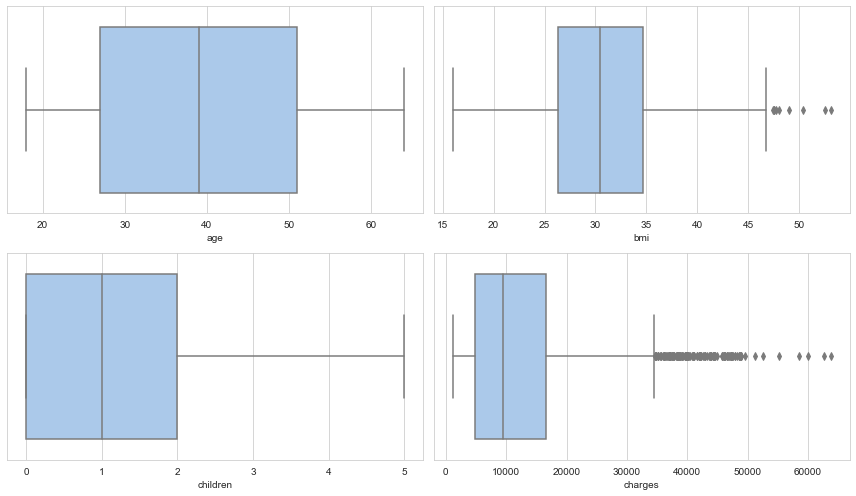

In [9]:
cols = 2
rows = 2
sns.set_palette("pastel")
sns.set_style("whitegrid")
num_cols = df.select_dtypes(exclude='category').columns
fig = plt.figure(figsize= (12,7))
for i, col in enumerate(num_cols):
    ax=fig.add_subplot( rows, cols, i+1)
    sns.boxplot(x=df[col], ax=ax)
    
fig.tight_layout()  
plt.show()

##### Histogram and Rug Plot

In [10]:
def plot_rug_hist(col_name):
    plt.figure(figsize= (12,7))
    sns.rugplot(x=col_name, data=df, height=.03, color='darkblue')
    sns.histplot(x=col_name, data=df, kde=True)
    plt.axvline(df[col_name].mean(), color='red', linestyle='--',linewidth=2, label='Mean')
    plt.axvline(df[col_name].median(), color='green', linestyle='--',linewidth=2, label='Median')
    plt.axvline(df[col_name].mode().tolist()[0], color='yellow', linestyle='--',linewidth=2, label='Mode')
    plt.legend()
    plt.show()

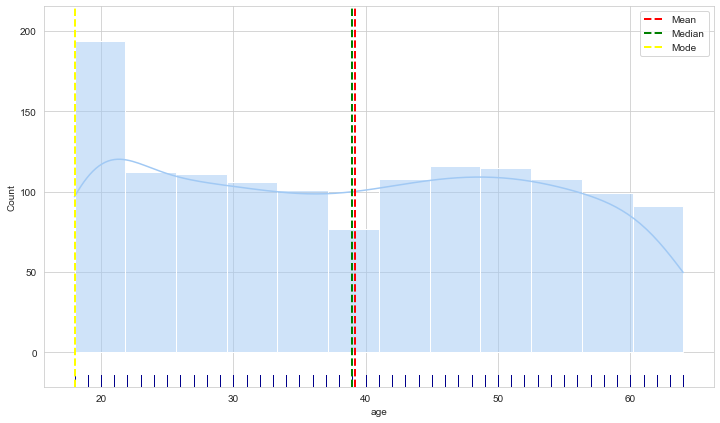

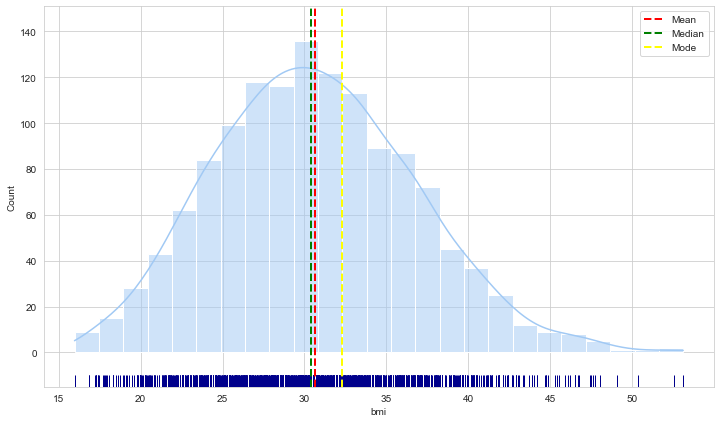

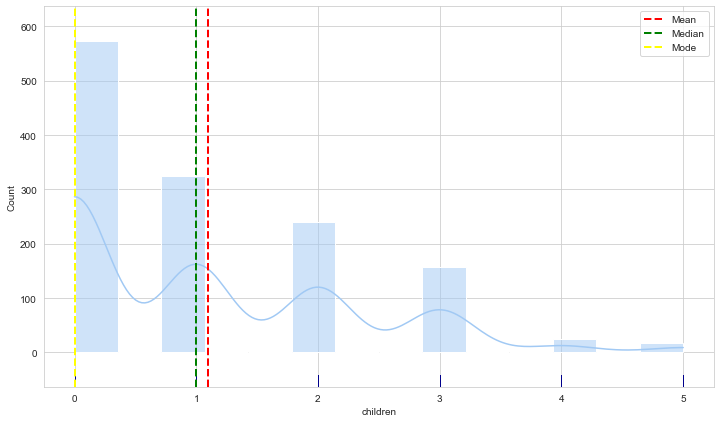

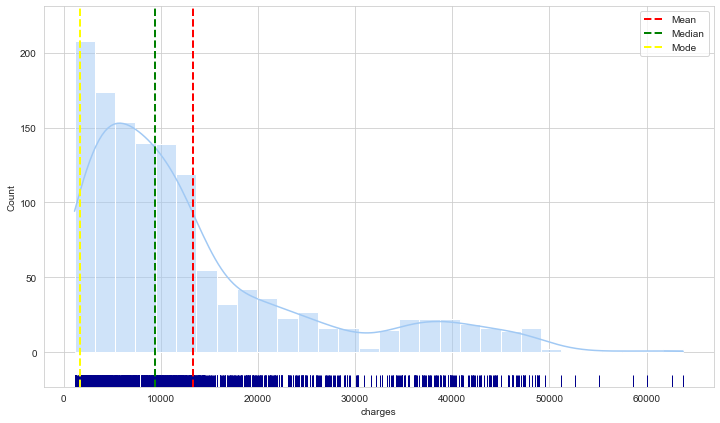

In [11]:
for i, col in enumerate(num_cols):
    plot_rug_hist(num_cols[i])

**Observations:**

- The age of primary beneficary lies approximately between 20 - 65 years. Since the mode is 18, we can safely say that majority of customer are 18 years old.
- BMI is normally distrubuted and the average BMI among the beneficiaries is 30 which is outside the normal range of BMI. It is also observed that there are lot of outliers at upper end.
- Majority of the beneficary have no children.
- The distribution for charges distrubution is unimodal and is right-skewed. There are lot of outliers at upper end.

##### Bar Plot

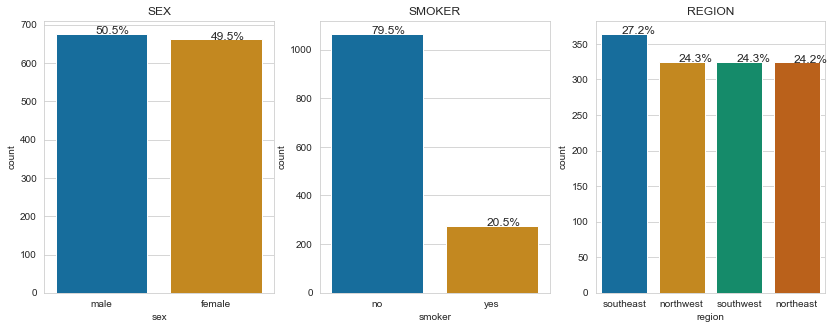

In [14]:
# Function to create barplots that indicate percentage of data for each category.
def percent_bar_plot(plot, feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        plot.annotate(percentage, (x, y), size = 12)
        
# Plot the Bar Chart
cat_cols =  df.select_dtypes(['category']).columns
fig, axes =plt.subplots(1,3,figsize=(14, 5))
for i in range(len(cat_cols)):
    order = df[cat_cols[i]].value_counts(ascending=False).index
    axis = sns.countplot(x=cat_cols[i], data=df, order=order, ax=axes[i], palette='colorblind').set(title=cat_cols[i].upper())
    percent_bar_plot(axes[i], df[cat_cols[i]])

**Observations:**

- 50.5% of the beneficiaries are male and 49.5% are female. So we approximately have the same number of male and female beneficiaries.
- Only 20.5% of beneficary are smokers. Most of our beneficiaries are non-smokers.
- As observed from the chart, our beneficaries are evenly distributed across regions with South East being the most populous one (27.2%) with the rest of regions each containing around 24% approximately.

### Bivariate and Multivariate Analysis

##### Correlation among Features

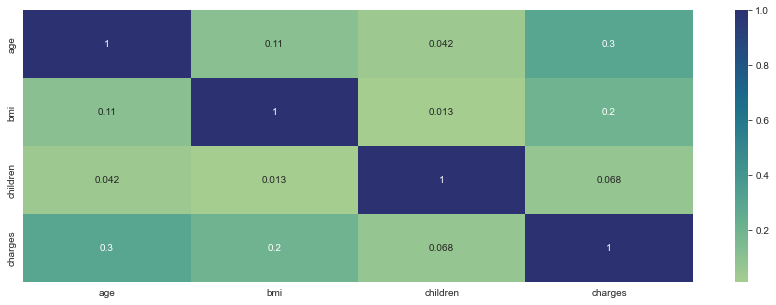

In [15]:
plt.figure(figsize=(15,5))
sns.heatmap(df.corr(), annot=True, cmap='crest')
plt.show()

**Observations:**
- We see that there is slighly significant positive correlation betweem `age` and `charges` & `bmi` and `charges`.

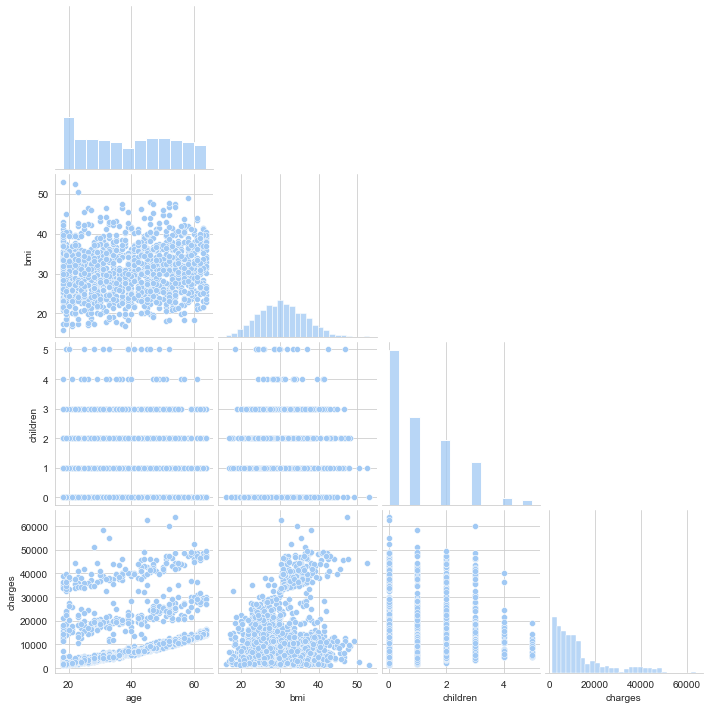

In [16]:
sns.pairplot(data=df, corner=True)
plt.show()

**Observations:**
- We can see that there is almost a slight linear increase in `charges` with increase in `age` which makes sense as medical bills increase as one gets older.
- We also observe that people with higher `bmi` pay more `charges` than people with lower `bmi`.

##### Sex vs All Numerical Features

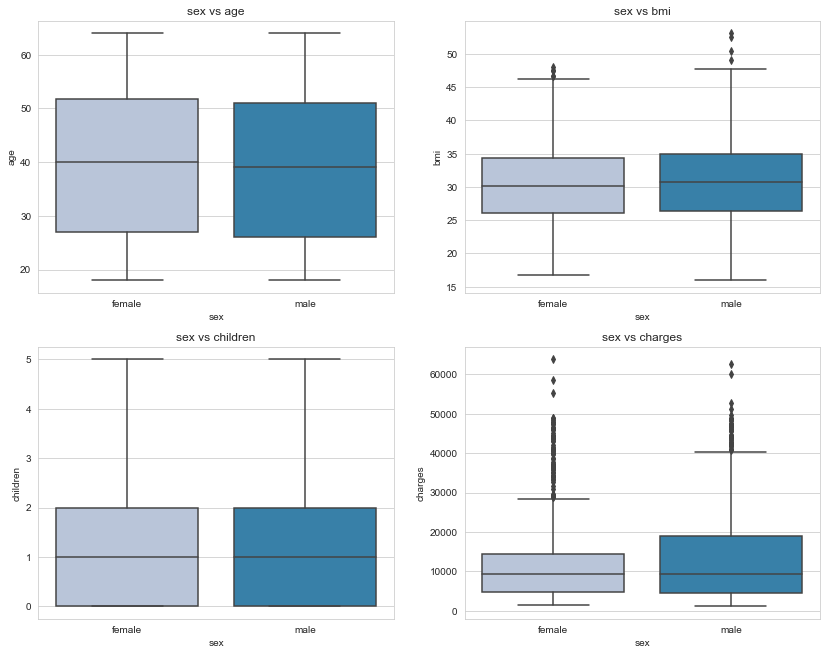

In [17]:
def cat_vs_all_numerical(feature):
    fig, axes =plt.subplots(2,2,figsize=(14, 11))
    for i in range(len(num_cols)):
        row = i//2
        col = i%2
        ax = axes[row, col]
        sns.boxplot(y=df[num_cols[i]], x=df[feature], ax=ax, palette="PuBu", orient='v').set(title='{} vs '.format(feature)+ num_cols[i])
        
cat_vs_all_numerical('sex')

**Observations:**

- Average age of female beneficiaries is slightly higher than the male beneficiaries.
- No. of children from both male and female beneficary have is same.
- BMI of male beneficiaries has many outliers and average BMI of male is slightly higher than female.
- Male beneficiaries have incurred more charges to insurance compared to female beneficiaries. There are lot of outliers in female beneficiaries.

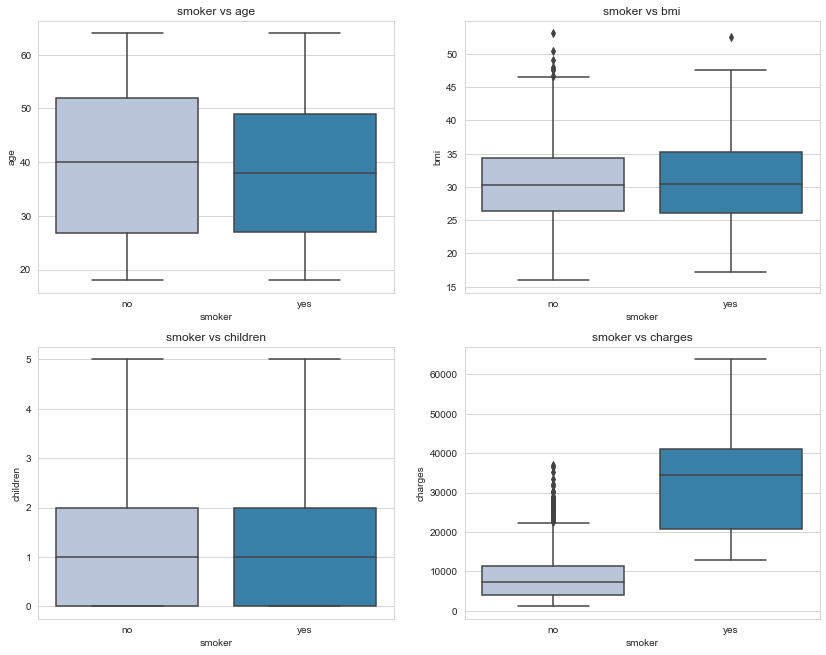

In [18]:
cat_vs_all_numerical('smoker')

**Observations:**
- Smokers have incured more cost for insurance than nonsmoker beneficiaries. Non-smokers also have a lot of outliers.
- The BMI of non smokers has a lot of outliers.

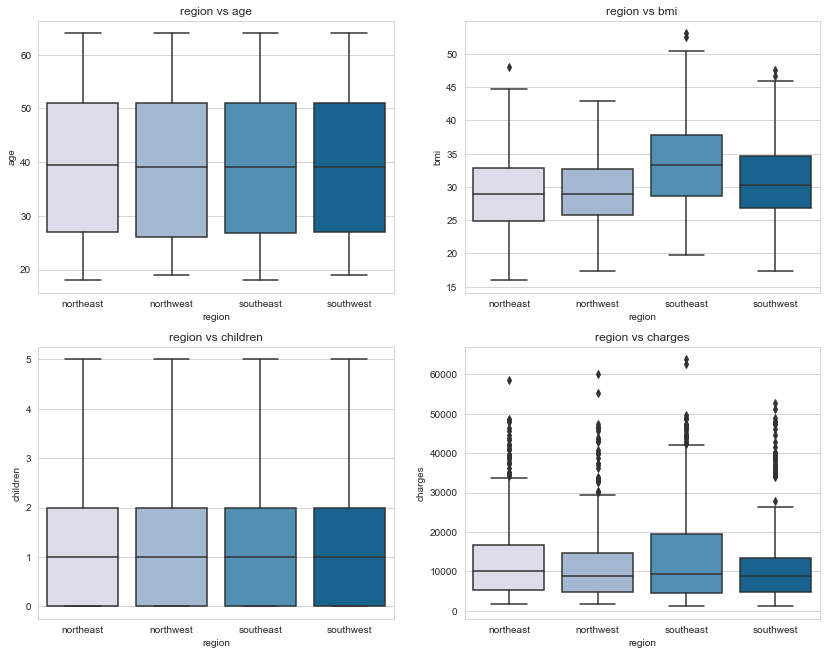

In [19]:
cat_vs_all_numerical('region')

**Observations**:

- The age and numnber of children across regions is almost the same.
- The average BMI of beneficiaries from southeast is higher compared to other regions.
- Beneficiaries from the southeast have incurred more charges compared to the beneficiaries from other regions.
- We observe a lot of outliers in the region vs charges box plots.

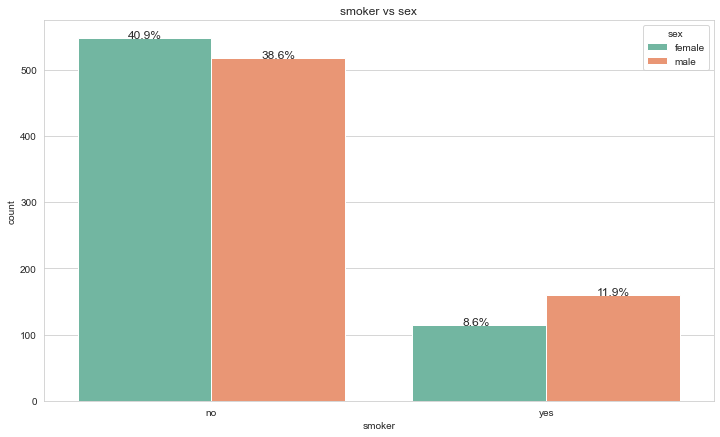

In [23]:
def compare_bar_plots(feature1, feature2):
    plt.figure(figsize=(12, 7))
    ax=sns.countplot(x=feature1, hue=feature2, data=df, palette='Set2')
    percent_bar_plot(ax, df[feature2])
    ax.set(title="{} vs {}".format(feature1, feature2))
    
compare_bar_plots('smoker', 'sex')

**Observation:**
- Among non-smokers, we have more females than males.
- On the other hand, we have more male smokers (3.3% higher) than female smokers.

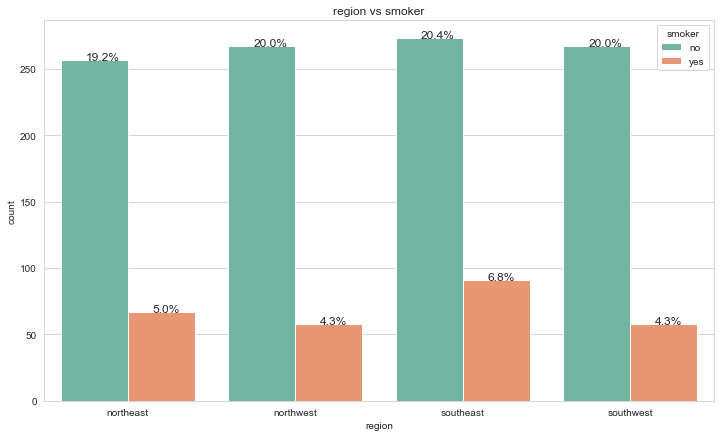

In [25]:
compare_bar_plots('region', 'smoker')

**Observations**:
- It is observed that there is roughly the same percentage of non-smokers across all regions.
- The northwest and southwest regions have relatively lower percentage of smokers. The southeast region has the highest percentage of smokers among all regions at 6.8%.

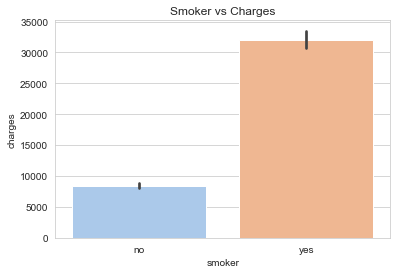

In [28]:
sns.barplot(x=df.smoker, y=df.charges).set(title="Smoker vs Charges");

**Observations**:
- Smokers have higher charges in insurance claims than non-smokers.

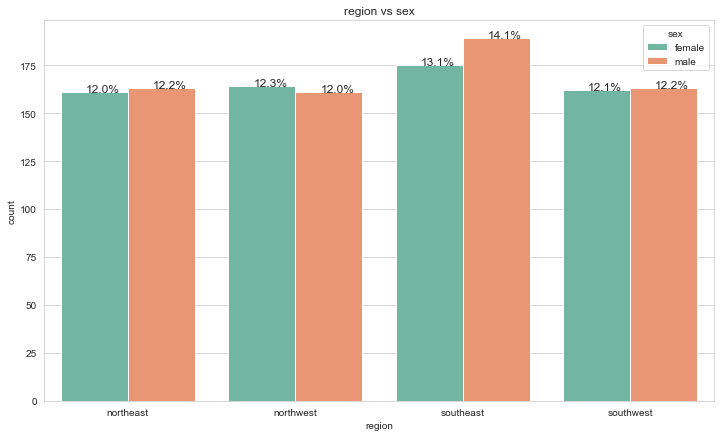

In [29]:
compare_bar_plots('region', 'sex')

**Observations:**
- With the exception of the southeast region, there is hardly any difference between the number of male and female beneficiaries.

In [31]:
df.groupby(df.sex).charges.mean()

sex
female    12569.578844
male      13956.751178
Name: charges, dtype: float64

**Observations:**
- The mean charges in insurance claims of males is higher than that of females.

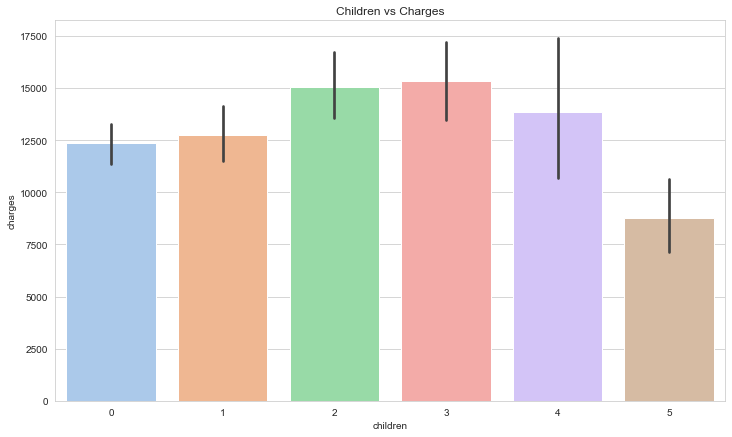

In [35]:
plt.figure(figsize=(12, 7))
sns.barplot(x=df.children, y=df.charges).set(title="Children vs Charges");

**Observations:**
- People with 2-3 children as dependents on the insurance had higher claim charges.

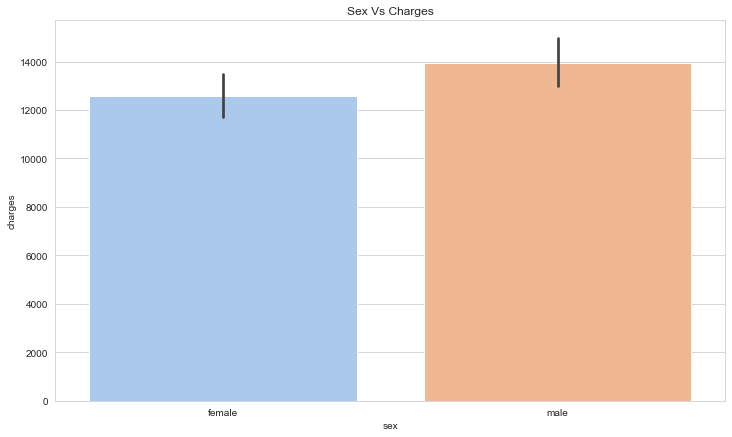

In [37]:
plt.figure(figsize=(12, 7))
sns.barplot(x=df.sex, y=df.charges).set(title='Sex Vs Charges');

**Observations:**
- Male beneficiaries had higher claim charges than female beneficiaries.

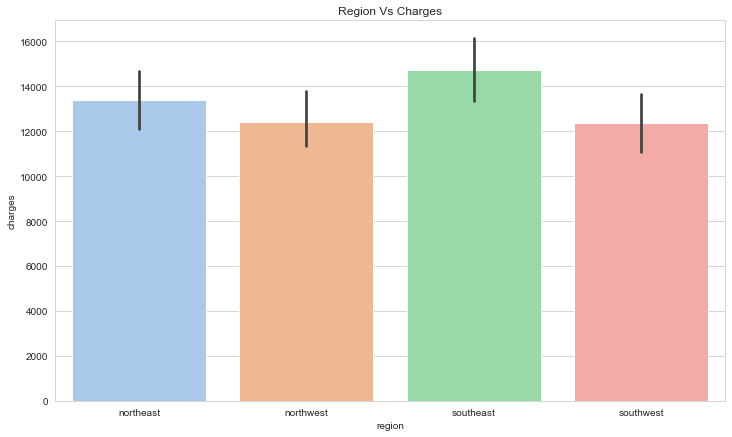

In [39]:
plt.figure(figsize=(12, 7))
sns.barplot(x='region',y='charges',data=df).set(title='Region Vs Charges');

**Observations:**
- Beneficiaries in the southeast have higher claim charges than other regions.

C:\Users\kedar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


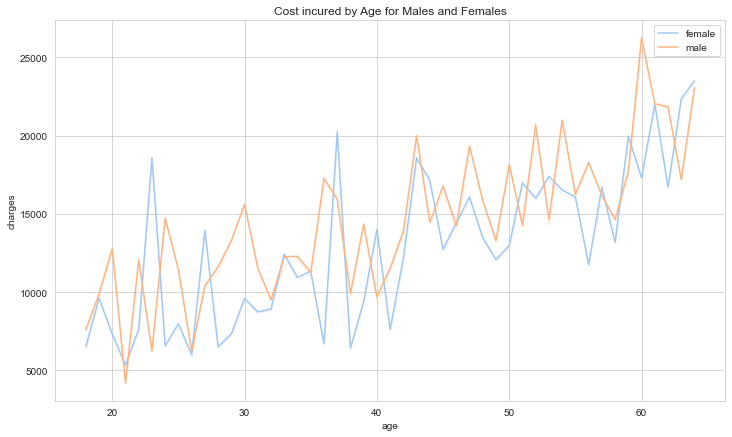

In [42]:
plt.figure(figsize=(12,7))
sns.lineplot(df['age'], df['charges'], hue=df['sex'], ci=0).set(title= 'Cost incured by Age for Males and Females')
plt.legend(bbox_to_anchor=(1.00, 1))
plt.show()

**Observations:**
- With increasing age, the charges has increased for both males and females.
- There some spikes for female at an approximately at the ages of 23, 28 and 43.

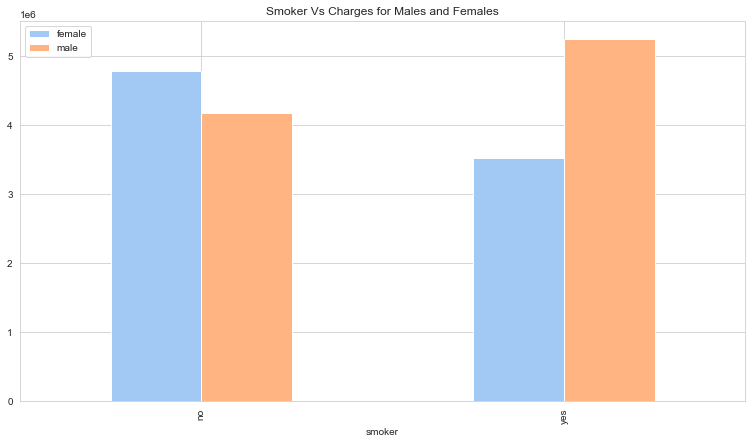

In [43]:
df_smoker_char_sex = pd.crosstab(index=df.smoker,columns=df.sex ,values=df.charges, aggfunc='sum')
fig1, axes1 = plt.subplots(1,1,figsize=(13, 7))
df_smoker_char_sex.plot(kind='bar', ax=axes1, title="Smoker Vs Charges for Males and Females")
plt.legend(loc='upper left')
plt.show()

**Observations:**
- Males who smoke have the most claims and have higher charges.
- Number of claims made by females who dont smoke is more compared to females who smoke.

##### Grouping The Data By BMI of Policy Holders

In [45]:
category = pd.cut(df.bmi, bins=[15,25,35,45,55], labels=['15-25','25-35','35-45','45-55'])
df.insert(5, 'BMIGroup', category)

In [46]:
df.head()

,age,sex,bmi,children,smoker,BMIGroup,region,charges
0,19,female,27.900,0,yes,25-35,southwest,16884.92400
1,18,male,33.770,1,no,25-35,southeast,1725.55230
2,28,male,33.000,3,no,25-35,southeast,4449.46200
3,33,male,22.705,0,no,15-25,northwest,21984.47061
4,32,male,28.880,0,no,25-35,northwest,3866.85520


In [47]:
df.groupby(df.BMIGroup).charges.mean()

BMIGroup
15-25    10284.290025
25-35    12720.254311
35-45    16913.681515
45-55    17547.926750
Name: charges, dtype: float64

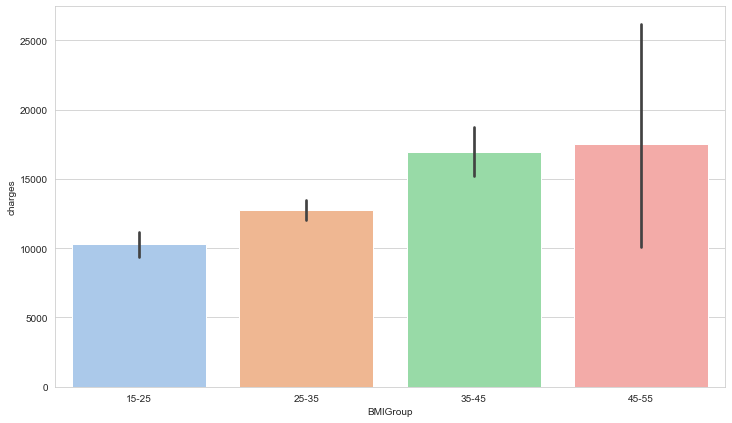

In [54]:
plt.figure(figsize=(12,7))
sns.barplot(x=df.BMIGroup, y=df.charges);

**Observations:**
- People with a lower BMI have lower charges compared to people with higher BMIs.

##### Grouping The Data By Age of Policy Holders

In [48]:
category1 = pd.cut(df.age, bins=[18,28,38,48,58,68], labels=['18-28','28-38','38-48','48-58','58-68'])
df.insert(6,'AgeBin', category1)

In [49]:
df.groupby(df.AgeBin).charges.mean()

AgeBin
18-28     9528.142786
28-38    11598.554943
38-48    14334.585843
48-58    15887.954341
58-68    20824.972901
Name: charges, dtype: float64

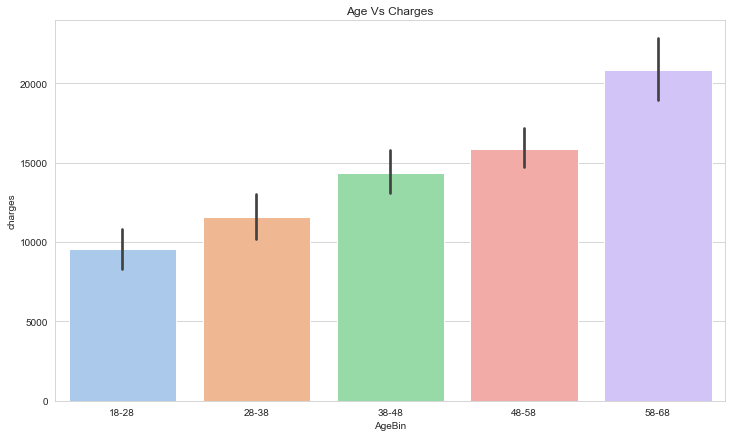

In [52]:
plt.figure(figsize=(12,7))
sns.barplot(x=df.AgeBin, y=df.charges).set(title='Age Vs Charges');

**Observations:**
- People with a lower age range have lower charges compared to older people.

##### Mean Charges by Smokers by Sex in different regions

In [50]:
df.groupby(['region','sex','smoker']).mean()['charges'].unstack()

smoker                     no           yes
region    sex                              
northeast female  9640.426984  28032.046398
          male    8664.042222  30926.252583
northwest female  8786.998679  29670.824946
          male    8320.689321  30713.181419
southeast female  8440.205552  33034.820716
          male    7609.003587  36029.839367
southwest female  8234.091260  31687.988430
          male    7778.905534  32598.862854

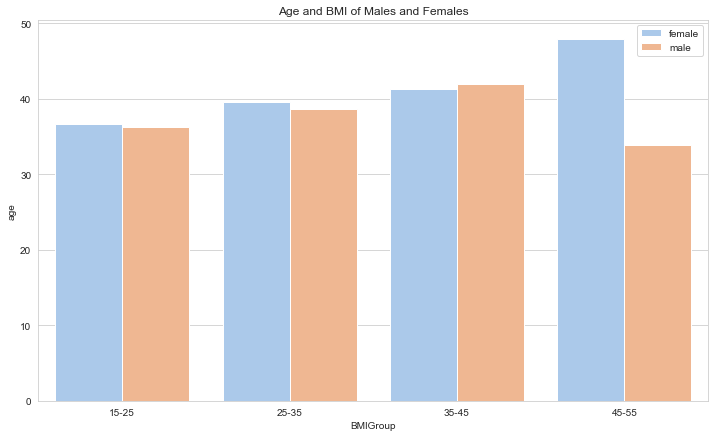

In [56]:
plt.figure(figsize=(12,7))
sns.barplot(x=df["BMIGroup"], y=df["age"], hue=df['sex'], ci=0).set(title= 'Age and BMI of Males and Females')
plt.legend(bbox_to_anchor=(1.00, 1))
plt.show()

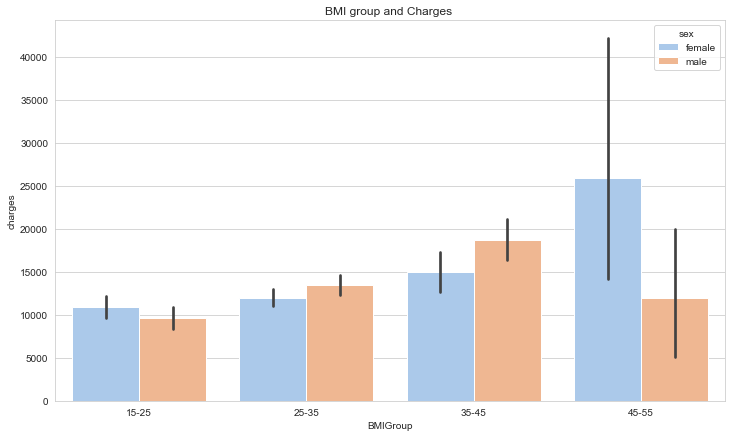

In [58]:
plt.figure(figsize=(12,7))
sns.barplot(x='BMIGroup', y='charges', hue='sex', data=df).set(title="BMI group and Charges");

**Observations:**
- Females with most BMI has incured most charges in insurance claims.

In [59]:
pd.crosstab(df['sex'], df['children'])

children,0,1,2,3,4,5
sex,,,,,,
female,289,158,119,77,11,8
male,285,166,121,80,14,10


<Figure size 864x576 with 0 Axes>

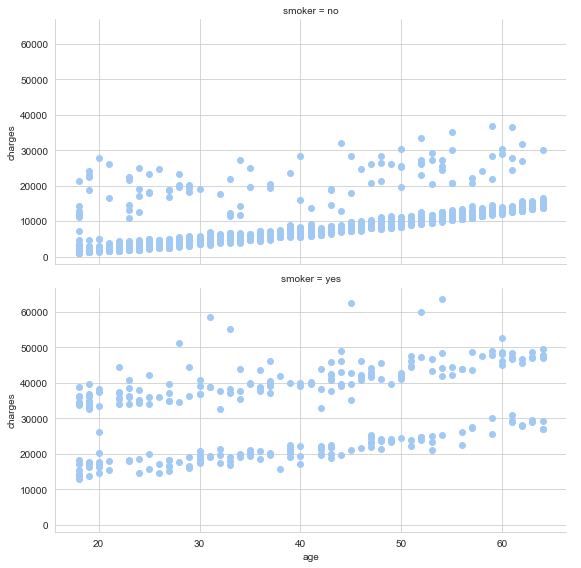

In [61]:
plt.figure(figsize=(12,8))
g=sns.FacetGrid(df, row='smoker', height=4, aspect=2)
g=(g.map(plt.scatter ,'age','charges').add_legend());

**Observations:**
- Young people who don't smoke have lowest insurance charges and non-smokers have a steady linear but low rise in charges.
- However, smokers in general, regardless of their age have higher insurance claim charges.

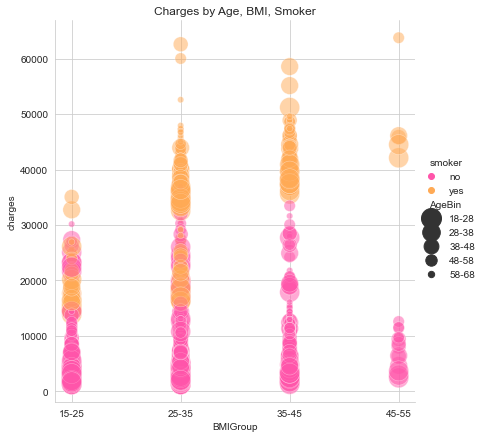

In [65]:
sns.relplot(x=df.BMIGroup, y=df.charges, hue=df.smoker, size= df.AgeBin,
            sizes=(40, 400), alpha=.5, palette="spring",
            height=6, data=df).set(title='Charges by Age, BMI, Smoker')
plt.show();

**Observations:**
- Males who smoke have incured more cost compared to nonsmokers.
- As age increased claims increased - Smokers have higher medical claims.
- High BMI and smokers have high insurance claim charges.

### Conclusions Based on Exploratory Data Analysis

- Insurances charges increases as age of the beneficiary increases.
- Males who smoke have higher charges.
- Females who are nonsmoker also have more claims to nonsmoker males and most of the time at a younger age. This may be because of child birth.
- Customer with BMI >30 are ones with high obesity. They have more health issues and have higher claims.